In [9]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

%config InlineBackend.figure_format = 'svg'
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

In [10]:
# Исходные данные для выполнения ДЗ

a_t=2.2 # Размер танка a
b_t=1.7 # Размер танка b

a=2.4 # Размер САУ a
b=2.2 # Размер САУ b

n_100t=14 # Скорострельность, 1/мин
n_100=10 # Скоростельность, 1/мин
n_152=9 # Скоростельность, 1/мин

PTRK_type='ком' # Тип ПТРК

X_0=2800 # Начальное расстояние
omega_100t=1.5 # Среднее число попаданий, необходимое для поражения целей
omega_100=1.6 # Среднее число попаданий, необходимое для поражения целей
omega_152=1.1 # Среднее число попаданий, необходимое для поражения целей
omega_PTUR=1.3 # Среднее число попаданий, необходимое для поражения целей

V_t=9 # Скорость танка
V_PTUR=260 # Скорость ПТУР
t_0=4 # Время, спустя которое в работу включается Т

ExX_100t=1/900 # Характеристики рассеивания
ExX_100=1/1400 # Характеристики рассеивания
ExX_152=1/800 # Характеристики рассеивания
ExX_PTUR=1/1700 # Характеристики рассеивания

# # Исходные данные для выполнения ДЗ

# a_t=3 # Размер танка a
# b_t=2.1 # Размер танка b

# a=2.8 # Размер САУ a
# b=1.9 # Размер САУ b

# n_100t=12 # Скорострельность, 1/мин
# n_100=11 # Скоростельность, 1/мин
# n_152=6 # Скоростельность, 1/мин

# PTRK_type='ком' # Тип ПТРК

# X_0=2000 # Начальное расстояние
# omega_100t=1.8 # Среднее число попаданий, необходимое для поражения целей
# omega_100=1.6 # Среднее число попаданий, необходимое для поражения целей
# omega_152=1.1 # Среднее число попаданий, необходимое для поражения целей
# omega_PTUR=1.2 # Среднее число попаданий, необходимое для поражения целей

# V_t=16 # Скорость танка
# V_PTUR=170 # Скорость ПТУР
# t_0=4 # Время, спустя которое в работу включается Т

# ExX_100t=1/1500 # Характеристики рассеивания
# ExX_100=1/600 # Характеристики рассеивания
# ExX_152=1/1000 # Характеристики рассеивания
# ExX_PTUR=1/2000 # Характеристики рассеивания

In [11]:
def get_F_x(x):
    """
    Функция Лапласса
        Аргументы:
            -x (flaot) - аргумент функции
        Результат:
            -Ф(х) (float) - значение функции Лапласса для аргумента х
    """
    return scipy.stats.norm.cdf(x)-0.5

def get_sigma(x, E_x):
    """
    Среднее квадратическое отклонение в зависимости от дальности
        Аргументы:
            - x (float) - дальность;
            - E_x (float) - характеристика рассеивания;
        Резульат:
            - sigma (float) - значение среднеквадратического отклонения
    """
    return 1.48*E_x*x

def get_P(a,b,E_x,x):
    """
    Вероятность попадания при одном выстреле
        Аргументы:
            - a (float) - размер а;
            - b (float) - размер b;
            - E_x (float) - характеристика рассеивания;
            - x (float) - дальность;
        Результаты:
            - P (float) - вероятность попадания при одном выстреле.
    """
    P=4*get_F_x((b/2)/get_sigma(x,E_x))*get_F_x((a/2)/get_sigma(x,E_x))
    return P

def get_W(a,b,E_x,x,omega):
    return get_P(a,b,E_x,x)/omega

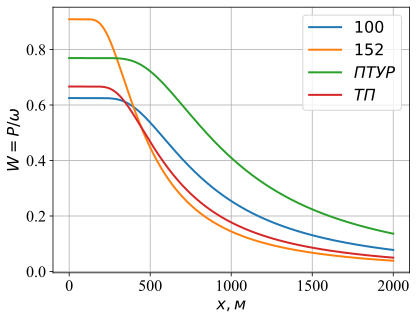

In [12]:
# Графики зависимости вероятности поражения от расстояния

X=np.linspace(0.01, 2e3, 1000)
plt.plot(X, get_W(a_t,b_t,ExX_100,X,omega_100), label='$100$', lw=2)
plt.plot(X, get_W(a_t,b_t,ExX_152,X,omega_152), label='$152$', lw=2)
plt.plot(X, get_W(a_t,b_t,ExX_PTUR,X,omega_PTUR), label='$ПТУР$', lw=2)
plt.plot(X, get_W(a,b,ExX_100t,X,omega_100t), label='$ТП$', lw=2)
plt.xlabel('$x, м$')
plt.ylabel('$W=P/\omega$')
plt.legend(loc='best')
plt.grid()
plt.show()

In [13]:
# Таблица W(P)
x_df=np.linspace(2800,0, round((2800-0)/100+1)) # Массив значений расстояний
sigma_100_df=[]
sigma_152_df=[]
sigma_100t_df=[]
F_a_100_df=[]
F_b_100_df=[]
F_a_152_df=[]
F_b_152_df=[]
F_a_100t_df=[]
F_b_100t_df=[]
W_100_df=[]
W_152_df=[]
W_100t_df=[]

for i in range(len(x_df)):
    if x_df[i]==0:
        x_df[i]=1e-7
    sigma_100_df.append(1.48*ExX_100*x_df[i])
    sigma_152_df.append(1.48*ExX_152*x_df[i])
    sigma_100t_df.append(1.48*ExX_100t*x_df[i])
    F_a_100_df.append(get_F_x(0.5*a_t/(1.48*ExX_100*x_df[i])))
    F_b_100_df.append(get_F_x(0.5*b_t/(1.48*ExX_100*x_df[i])))
    F_a_152_df.append(get_F_x(0.5*a_t/(1.48*ExX_152*x_df[i])))
    F_b_152_df.append(get_F_x(0.5*b_t/(1.48*ExX_152*x_df[i])))
    F_a_100t_df.append(get_F_x(0.5*a/(1.48*ExX_100t*x_df[i])))
    F_b_100t_df.append(get_F_x(0.5*b/(1.48*ExX_100t*x_df[i])))
    W_100_df.append(get_W(a_t,b_t,ExX_100,x_df[i],omega_100))
    W_152_df.append(get_W(a_t,b_t,ExX_152,x_df[i],omega_152))
    W_100t_df.append(get_W(a,b,ExX_100t,x_df[i],omega_100t))

# Запись в таблицу
df_W = pd.DataFrame()
df_W['x,м']=x_df
df_W['sigma_100']=sigma_100_df
df_W['sigma_152']=sigma_152_df
df_W['sigma_100t']=sigma_100t_df
df_W['F_a_100']=F_a_100_df
df_W['F_b_100']=F_b_100_df
df_W['F_a_152']=F_a_152_df
df_W['F_b_152']=F_b_152_df
df_W['F_a_100t']=F_a_100t_df
df_W['F_b_100t']=F_b_100t_df
df_W['W_100']=W_100_df
df_W['W_152']=W_152_df
df_W['W_100t']=W_100t_df

# Отображение таблицы
pd.options.display.float_format = '{:,.3f}'.format
df_W

,"x,м",sigma_100,sigma_152,sigma_100t,F_a_100,F_b_100,F_a_152,F_b_152,F_a_100t,F_b_100t,W_100,W_152,W_100t
0,"2,800.000",2.960,5.180,4.604,0.145,0.113,0.084,0.065,0.103,0.094,0.041,0.020,0.026
1,"2,700.000",2.854,4.995,4.440,0.150,0.117,0.087,0.068,0.107,0.098,0.044,0.021,0.028
2,"2,600.000",2.749,4.810,4.276,0.155,0.121,0.090,0.070,0.111,0.102,0.047,0.023,0.030
3,"2,500.000",2.643,4.625,4.111,0.161,0.126,0.094,0.073,0.115,0.105,0.051,0.025,0.032
4,"2,400.000",2.537,4.440,3.947,0.168,0.131,0.098,0.076,0.119,0.110,0.055,0.027,0.035
5,"2,300.000",2.431,4.255,3.782,0.175,0.137,0.102,0.079,0.124,0.114,0.060,0.029,0.038
6,"2,200.000",2.326,4.070,3.618,0.182,0.143,0.107,0.083,0.130,0.119,0.065,0.032,0.041
7,"2,100.000",2.220,3.885,3.453,0.190,0.149,0.111,0.087,0.136,0.125,0.071,0.035,0.045
8,"2,000.000",2.114,3.700,3.289,0.199,0.156,0.117,0.091,0.142,0.131,0.078,0.039,0.050
9,"1,900.000",2.009,3.515,3.124,0.208,0.164,0.123,0.096,0.150,0.138,0.085,0.043,0.055


In [14]:
# Дуэль Т и САУ с 100-мм ПТП

def get_X_tek(t, X_0, v_t):
    """
    Расстояние между машинами
        Аргументы:
            -t (float) - время движения;
            -X_0 (float) - начальное расстояние;
            -v_t (float) - скорость сближения;
        Результат:
            -X (float) - текущее положение.
    """
    return X_0-v_t*t

delta_t_100=60/n_100 # Время, через которое САУ делает выстрел
delta_t_100t=60/n_100t # Время, через котрое Т делает выстрел

t_T_SAU=np.linspace(0, 110)
t_100ti=np.linspace(0, 25*delta_t_100t, round((25*delta_t_100t-0)/delta_t_100t)+1) # моменты времени + 4с, в котороые стреляет Т
t_100i=np.linspace(0, 18*delta_t_100, (round(25*delta_t_100/delta_t_100)+1)) # моменты времени, в которые стреляет САУ

# Вероятность поражения танка при i-м выстреле
W_i = get_W(a_t,b_t,ExX_100,get_X_tek(t_100i, X_0, V_t),omega_100)

# Вероятность поражения САУ при i-м выстреле
V_i = get_W(a,b,ExX_100t,get_X_tek(t_100ti, X_0, V_t),omega_100t)

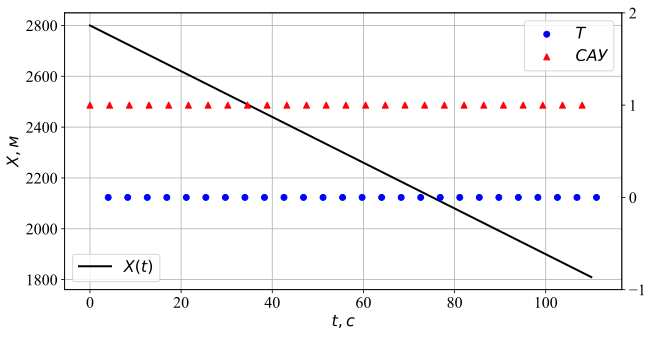

In [15]:
# Посследовательность выстрелов и расстояние от времени

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(t_T_SAU, get_X_tek(t_T_SAU, X_0, V_t), lw=2, color='black', label='$X(t)$')
ax1.set_xlabel('$t,c$')
ax1.set_ylabel('$X, м$')
ax1.grid()
ax1.legend(loc='lower left')
ax2 = ax1.twinx()
ax2.scatter(t_0+t_100ti, np.linspace(0,0, len(t_0+t_100ti)), color='blue', label='$Т$')
ax2.scatter(t_100i, np.linspace(1,1, len(t_100i)), color='red', marker='^', label='$САУ$')
ax2.set_yticks([-1,0,1,2]);
ax2.legend(loc='best');

In [16]:
df_T_vs_SAU = pd.DataFrame()
shots=np.linspace(0, 100, 101)
i=1
W1=get_W(a_t,b_t,ExX_100,get_X_tek(0, X_0, V_t),omega_100)
V1=get_W(a,b,ExX_100t,get_X_tek(t_0, X_0, V_t),omega_100t)
W1_=W1
V1_=(1-W1)*V1
Wi_=W1
Wi_min1_=0
Vi_=V1_
Vi_min1_=0
t_shot_SAU_1=shots[0]*delta_t_100 # время в которое происходит выстрел САУ
t_shot_t_1=4+shots[0]*delta_t_100
W_V=['W', 'V']
n_shots=[1,1]
t_shots=[t_shot_SAU_1, t_shot_t_1]
P_array=[(1-W1),(1-W1-V1)]
Krit_1=[1,1]
Krit_2=[1,1]
p=1
print('Vi_ = ',round(Vi_, 3), 't = ', t_shot_t_1)
print('Wi_ = ',round(Wi_, 3), 'i = ', t_shot_SAU_1)
while ((Wi_- Wi_min1_)/Wi_ > 0.01) or ((Vi_- Vi_min1_)/Vi_ > 0.01):
    t_shot_SAU=shots[i]*delta_t_100 # время в которое происходит выстрел САУ
    t_shot_t=4+shots[i]*delta_t_100t # время в которое происходит выстрел Т
    Wi_min1=Wi
    Vi_min1=Vi
    Wi=get_W(a_t,b_t,ExX_100,get_X_tek(t_shot_SAU, X_0, V_t),omega_100)
    Vi=get_W(a,b,ExX_100t,get_X_tek(t_shot_t, X_0, V_t),omega_100t)
    Wi_min1_=Wi_
    Wi_=Wi_min1_+p*(1-Wi_min1)*(1-Vi_min1)
    Vi_min1_=Vi_
    Wip1=get_W(a_t,b_t,ExX_100,get_X_tek(t_shot_SAU, X_0, V_t),omega_100)
    Vi_=Vi_min1_+p*(1-Wi_min1)*(1-Vi_min1)*(1-Wi)*Vi
    p=(1-Wi_min1)*(1-Vi_min1)*p
    
    print('Vi_ = ',round(Vi_, 3), 't = ', t_shot_t)
    print('Wi_ = ',round(Wi_, 3), 'i = ', t_shot_SAU)
    i=i+1

    # if t_shot_SAU>t_shot_t:
    #     W_V.append('W')
    #     n_shots.append()

Vi_ =  0.025 t =  4.0
Wi_ =  0.041 i =  0.0
Vi_ =  0.05 t =  8.285714285714285
Wi_ =  0.975 i =  6.0
Vi_ =  0.073 t =  12.571428571428571
Wi_ =  1.844 i =  12.0
Vi_ =  0.095 t =  16.857142857142858
Wi_ =  2.652 i =  18.0
Vi_ =  0.117 t =  21.142857142857142
Wi_ =  3.4 i =  24.0
Vi_ =  0.137 t =  25.428571428571427
Wi_ =  4.092 i =  30.0
Vi_ =  0.156 t =  29.714285714285715
Wi_ =  4.729 i =  36.0
Vi_ =  0.174 t =  34.0
Wi_ =  5.314 i =  42.0
Vi_ =  0.191 t =  38.285714285714285
Wi_ =  5.849 i =  48.0
Vi_ =  0.206 t =  42.57142857142857
Wi_ =  6.338 i =  54.0
Vi_ =  0.221 t =  46.857142857142854
Wi_ =  6.781 i =  60.0
Vi_ =  0.235 t =  51.14285714285714
Wi_ =  7.183 i =  66.0
Vi_ =  0.248 t =  55.42857142857143
Wi_ =  7.545 i =  72.0
Vi_ =  0.26 t =  59.714285714285715
Wi_ =  7.869 i =  78.0
Vi_ =  0.271 t =  64.0
Wi_ =  8.159 i =  84.0
Vi_ =  0.28 t =  68.28571428571428
Wi_ =  8.416 i =  90.0
Vi_ =  0.29 t =  72.57142857142857
Wi_ =  8.644 i =  96.0
Vi_ =  0.298 t =  76.85714285714286
W

In [17]:
delta_t_100t

4.285714285714286